In [1]:
import numpy as np
import tensorflow as tf
import cv2
import processing
import model
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
import pickle
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
%matplotlib inline

Using TensorFlow backend.


In [2]:
if '__file__' not in globals():
    CURRENT_DIR = os.getcwd()
else:
    CURRENT_DIR = os.path.dirname(os.path.realpath(__file__))

In [3]:
print(CURRENT_DIR)

/home/ubuntu/repositories/speed-challenge


In [4]:

DATA_PATH = os.path.join(CURRENT_DIR, 'data')
TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4')
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')
PREPARED_DATA_PATH = os.path.join(CURRENT_DIR, 'prepared-data')
PREPARED_IMGS_TRAIN = os.path.join(PREPARED_DATA_PATH, 'train_imgs')
PREPARED_IMGS_TEST = os.path.join(PREPARED_DATA_PATH, 'test_imgs')
ASSETS_PATH = os.path.join(CURRENT_DIR, 'assets')

# hyperparameters
batch_size = 16
num_epochs = 25  # 100 #90
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia'
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                           batch_size,
                                                                           num_epochs,
                                                                           steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets', run_name)
fig_loc = os.path.join(assets_filepath, 'distribution.png')
weights_loc = os.path.join(assets_filepath, 'weights.h5')
history_loc = os.path.join(assets_filepath, 'history.p')
tensorboard_loc = os.path.join(assets_filepath, run_name)

In [5]:
def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1

        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()

        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis=0,
                                   join='outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis=0,
                                   join='outer', ignore_index=False)
    return train_data, valid_data

In [6]:
def generate_training_data(data, batch_size=32):
    image_batch = np.zeros((batch_size, 66, 220, 3))  # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, 4)

            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()

            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()

            # Find the 3 respective times to determine frame order (current -> next)

            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]

            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now

            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')
            x1, y1 = processing.load_and_preprocess_image(row1['image_path'].values[0],
                                                          row1['speed'].values[0],
                                                          True,
                                                          bright_factor)

            # preprocess another image
            x2, y2 = processing.load_and_preprocess_image(row2['image_path'].values[0],
                                                          row2['speed'].values[0],
                                                          True,
                                                          bright_factor)

            # compute optical flow send in images as RGB
            rgb_diff = processing.opticalFlowDense(x1, x2)

            # calculate mean speed
            y = np.mean([y1, y2])

            image_batch[i] = rgb_diff
            label_batch[i] = y

        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)


In [7]:
def generate_validation_data(data):
    while True:
        # start from the second row because we may try to grab it and need its prev to be in bounds
        for idx in range(1, len(data) - 1):
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()

            # Find the 3 respective times to determine frame order (current -> next)

            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]

            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now

            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')
            x1, y1 = processing.load_and_preprocess_image(
                row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = processing.load_and_preprocess_image(
                row2['image_path'].values[0], row2['speed'].values[0])

            img_diff = processing.opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(
                1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])

            speed = np.array([[y]])

            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed



  0%|          | 29/20399 [00:00<01:10, 288.93it/s]

shape:  (20400, 3)


100%|██████████| 20399/20399 [01:16<00:00, 266.87it/s]


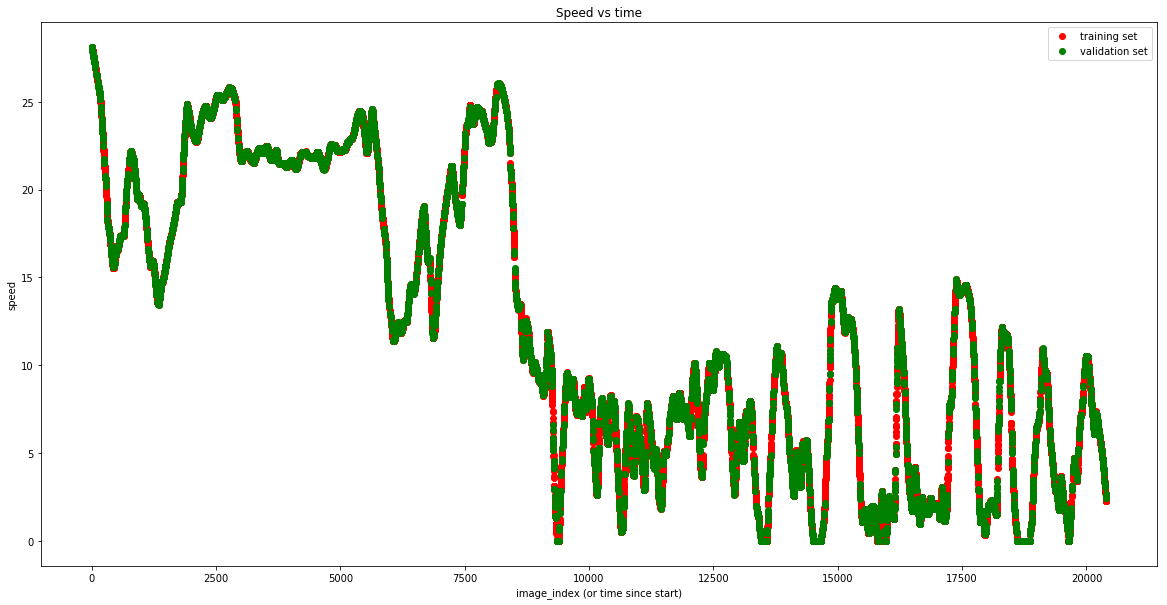

----
valid_data:  (9032, 4)
train_data:  (31766, 4)


In [8]:
# Create the assets folder
if not os.path.exists(assets_filepath):
        os.makedirs(assets_filepath)
train_meta = pd.read_csv(os.path.join(
        PREPARED_DATA_PATH, 'train_meta.csv'))
print('shape: ', train_meta.shape)
train_data, valid_data = train_valid_split(train_meta, 1)
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(train_data.sort_values(['image_index'])[
             ['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[
             ['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [9]:
valid_generator = generate_validation_data(valid_data)
val_size = len(valid_data.index)

earlyStopping = EarlyStopping(monitor='val_loss',
                                  patience=1,
                                  verbose=1,
                                  min_delta=0.23,
                                  mode='min',)

modelCheckpoint = ModelCheckpoint(weights_loc,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      mode='min',
                                      verbose=1,
                                      save_weights_only=True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                              write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]

CHANNEL = 3
WIDTH = 220
HEIGHT = 66

m = model.build_model(HEIGHT, WIDTH, CHANNEL)

m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 220, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 108, 24)       1824      
_________________________________________________________________
elu_1 (ELU)                  (None, 31, 108, 24)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 52, 36)        21636     
_________________________________________________________________
elu_2 (ELU)                  (None, 14, 52, 36)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 24, 48)         43248     
_________________________________________________________________
elu_3 (ELU)                  (None, 5, 24, 48)         0         
__________

In [10]:
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


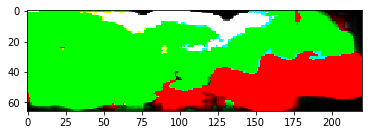

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22.454833


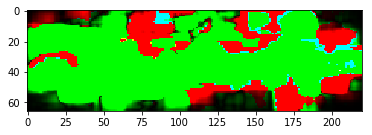

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


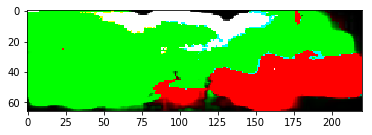

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


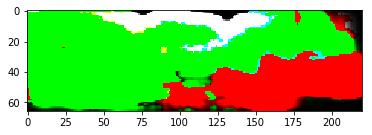

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


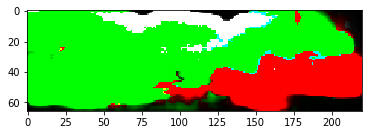

22.454833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


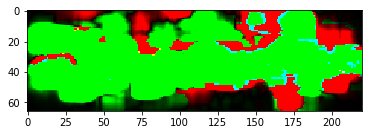

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


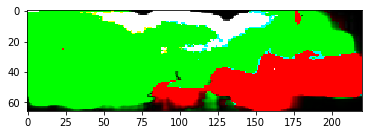

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


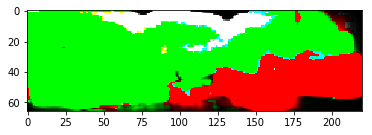

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


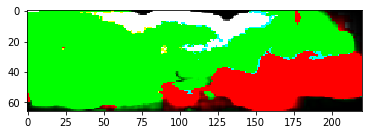

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.4602015


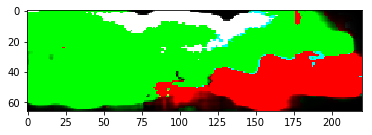

8.4602015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


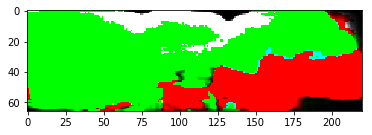

8.4602015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


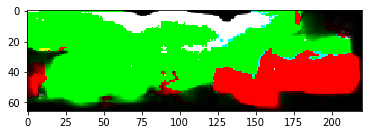

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22.454833


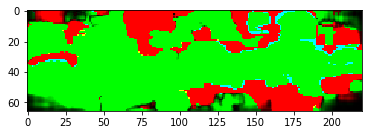

8.4602015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


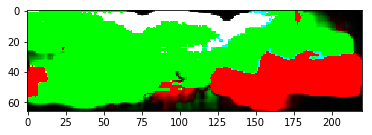

8.4602015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


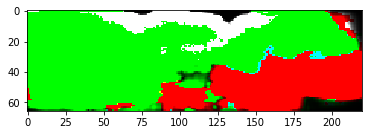

8.4602015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


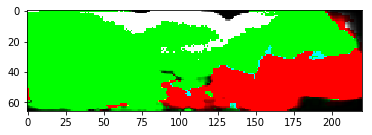

In [11]:
i = 0
for images,speeds in train_generator:
    if i == 1:
        break
    num_images = images.shape[0]
    for j in range(num_images):
        image = images[j,:,:,:]
        print(speeds[j])
        plt.imshow(image)
        plt.show()
    i+= 1

In [12]:
history = m.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        callbacks=callbacks_list,
        verbose=1,
        validation_data=valid_generator,
        validation_steps=val_size)

Epoch 1/25
400/400 [==============================] - 371s 929ms/step - loss: 34.2870 - val_loss: 92.9209

Epoch 00001: val_loss improved from inf to 92.92087, saving model to /home/ubuntu/repositories/speed-challenge/assets/model_assets/model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=400/weights.h5
Epoch 2/25
272/400 [===================>..........] - ETA: 40s - loss: 6.0114

KeyboardInterrupt: 

In [ ]:
print(history)

pickle.dump(history.history, open(history_loc, "wb"))